# TBR measurements

In [1]:
# download data from runs 100mL and runs 1, 2, 3
tbr_data = {
    "100ml_4": 3.42e-4,
    "100ml_5": 3.57e-4,
    "100ml_6": 3.83e-4,
}

modelled_tbr_100ml = 4.71e-4

import requests
import json


def get_data(url):
    # read json file from url
    response = requests.get(url)
    if response.status_code == 200:
        print("Download successful!")
        return json.loads(response.content.decode("utf-8"))
    else:
        print(f"Failed to download file. HTTP Status Code: {response.status_code}")
        return None


data_1l_run_1 = get_data(
    "https://raw.githubusercontent.com/LIBRA-project/BABY-1L-run-1/refs/heads/main/data/processed_data.json"
)
data_1l_run_2 = get_data(
    "https://raw.githubusercontent.com/LIBRA-project/BABY-1L-run-2/refs/heads/main/data/processed_data.json"
)
data_1l_run_3 = get_data(
    "https://raw.githubusercontent.com/LIBRA-project/BABY-1L-run-3/refs/heads/main/data/processed_data.json"
)

Download successful!
Download successful!
Download successful!


In [2]:
from libra_toolbox.tritium import ureg
from libra_toolbox.tritium.model import activity_to_quantity


def get_total_irradiation_time(data: dict) -> float:
    duration = 0
    irradiations = data["irradiations"]
    for irr in irradiations:
        start = irr["start_time"]["value"] * ureg(irr["start_time"]["unit"])
        end = irr["stop_time"]["value"] * ureg(irr["stop_time"]["unit"])
        duration += (end - start).to(ureg("s")).magnitude
    return duration


def get_neutron_fluence(data):
    # get neutron fluence from data
    irradiation_time = get_total_irradiation_time(data)
    neutron_rate = data["neutron_rate_used_in_model"]["value"] * ureg(
        data["neutron_rate_used_in_model"]["unit"]
    )
    neutron_rate = neutron_rate.to(ureg("neutron/s")).magnitude
    neutron_fluence = neutron_rate * irradiation_time
    return neutron_fluence


def get_total_tritium_prod(data) -> float:
    cumul_release = data["cumulative_tritium_release"]
    IV = cumul_release["IV"]["total"]
    OV = cumul_release["OV"]["total"]
    total_t = IV["value"][-1] * ureg(IV["unit"]) + OV["value"][-1] * ureg(OV["unit"])
    total_t = activity_to_quantity(total_t).to(ureg.particle).magnitude
    return total_t

In [3]:
import numpy as np

# Extract TBR data for 100 mL
measured_tbr_100ml = np.mean(
    list(tbr_data.values())
)

modelled_tbr_1l = data_1l_run_1.get("modelled_TBR", {}).get("mean", None)

total_neutron_fluence_1l = sum(
    [
        get_neutron_fluence(data_1l_run_1),
        get_neutron_fluence(data_1l_run_2),
        get_neutron_fluence(data_1l_run_3),
    ]
)
total_tritium_production_1l = sum(
    [
        get_total_tritium_prod(data_1l_run_1),
        get_total_tritium_prod(data_1l_run_2),
        get_total_tritium_prod(data_1l_run_3),
    ]
)

measured_tbr_1l = total_tritium_production_1l / total_neutron_fluence_1l


In [4]:
import pandas as pd

# Create a dictionary with the TBR data
data_dict = {
    "100 mL": {
        "measured_tbr": measured_tbr_100ml,
        "modelled_tbr": modelled_tbr_100ml,
    },
    "1 L (all)": {
        "measured_tbr": measured_tbr_1l,
        "modelled_tbr": modelled_tbr_1l,
        "neutron_fluence": total_neutron_fluence_1l,
        "tritium_production": total_tritium_production_1l
    },
    "1L run 1": {
        "measured_tbr": data_1l_run_1.get("measured_TBR", {}).get("value", None),
        "modelled_tbr": data_1l_run_1.get("modelled_TBR", {}).get("mean", None),
        "neutron_fluence": get_neutron_fluence(data_1l_run_1),
        "tritium_production": get_total_tritium_prod(data_1l_run_1),
    },
    "1L run 2": {
        "measured_tbr": data_1l_run_2.get("measured_TBR", {}).get("value", None),
        "modelled_tbr": data_1l_run_2.get("modelled_TBR", {}).get("mean", None),
        "neutron_fluence": get_neutron_fluence(data_1l_run_2),
        "tritium_production": get_total_tritium_prod(data_1l_run_2),
    },
    "1L run 3": {
        "measured_tbr": data_1l_run_3.get("measured_TBR", {}).get("value", None),
        "modelled_tbr": data_1l_run_3.get("modelled_TBR", {}).get("mean", None),
        "neutron_fluence": get_neutron_fluence(data_1l_run_3),
        "tritium_production": get_total_tritium_prod(data_1l_run_3),
    },
}

# Create a DataFrame
df_tbr = pd.DataFrame.from_dict(data_dict, orient='index')

# Display the DataFrame
display(df_tbr)

,measured_tbr,modelled_tbr,neutron_fluence,tritium_production
100 mL,0.000361,0.000471,NaN,NaN
1 L (all),0.002065,0.002042,3.855730e+13,7.961979e+10
1L run 1,0.002391,0.002042,3.951072e+12,9.446719e+09
1L run 2,0.001782,0.002040,3.010608e+13,5.364215e+10
1L run 3,0.004041,0.002040,4.500144e+12,1.653092e+10


In [5]:
import morethemes as mt

mt.set_theme("minimal")

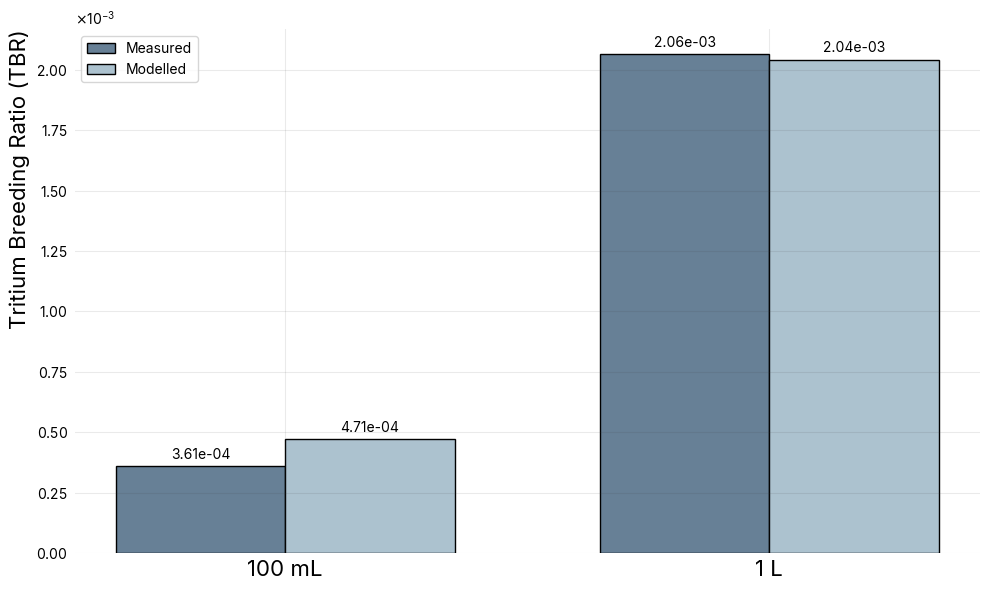

In [6]:

# plot of TBRs for 100 mL and 1L + comparison with OpenMC
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt

# Set up the data
x = np.arange(2)  # Two positions for 100 mL and 1L
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Create the bars
measured_bars = ax.bar(
    x - width / 2,
    [measured_tbr_100ml, measured_tbr_1l],
    width,
    label="Measured",
    edgecolor="black",
)
modelled_bars = ax.bar(
    x + width / 2,
    [modelled_tbr_100ml, modelled_tbr_1l],
    width,
    label="Modelled",
    edgecolor="black",
)


# Set up scientific notation for y-axis
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-3, -3))  # Force power of -3
ax.yaxis.set_major_formatter(formatter)

# Add labels, title and custom x-axis tick labels
ax.set_ylabel("Tritium Breeding Ratio (TBR)", fontsize=16)
# ax.set_title("Comparison of Measured vs Modelled TBR", fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(["100 mL", "1 L"], fontsize=16)
ax.legend()

# Add value labels using the built-in bar_label method
ax.bar_label(measured_bars, fmt="%.2e", padding=3)
ax.bar_label(modelled_bars, fmt="%.2e", padding=3)


plt.tight_layout()
plt.savefig("tbr_comparison.pdf")
plt.show()

In [7]:
from libra_toolbox.tritium.model import Model


def model_from_json(json_data: dict) -> Model:
    """
    Create a model from JSON data.
    """
    # Extract the relevant data from the JSON
    k_top = json_data["k_top"]["value"] * ureg(json_data["k_top"]["unit"])
    k_wall = json_data["k_wall"]["value"] * ureg(json_data["k_wall"]["unit"])
    neutron_rate = json_data["neutron_rate_used_in_model"]["value"] * ureg(
        json_data["neutron_rate_used_in_model"]["unit"]
    )
    irradiations = [
        (
            irr["start_time"]["value"] * ureg(irr["start_time"]["unit"]),
            irr["stop_time"]["value"] * ureg(irr["stop_time"]["unit"]),
        )
        for irr in json_data["irradiations"]
    ]

    # Create a new model instance with the extracted parameters
    model = Model(
        radius=json_data["modelled_baby_radius"]["value"]
        * ureg(json_data["modelled_baby_radius"]["unit"]),
        height=json_data["modelled_baby_height"]["value"]
        * ureg(json_data["modelled_baby_height"]["unit"]),
        TBR=json_data["TBR_used_in_model"]["value"]
        * ureg(json_data["TBR_used_in_model"]["unit"]),
        k_top=k_top,
        k_wall=k_wall,
        neutron_rate=neutron_rate,
        irradiations=irradiations,
    )

    return model


def scatter_stream(data, stream: str, **kwargs):
    data_stream = data["cumulative_tritium_release"][stream]
    sampling_times = data_stream["sampling_times"]["value"] * ureg(data_stream["sampling_times"]["unit"])
    cumulative_release = data_stream["total"]["value"] * ureg(data_stream["total"]["unit"])

    return plt.scatter(
        sampling_times, cumulative_release,  **kwargs
    )

/home/remidm/anaconda3/envs/baby-1l-paper/lib/python3.12/site-packages/scipy/integrate/_ivp/base.py:23: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(fun(t, y), dtype=dtype)


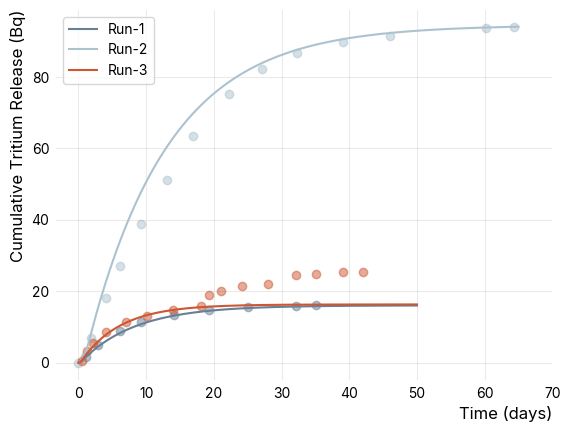

In [22]:
from libra_toolbox.tritium.plotting import plot_integrated_top_release
# run 1
model_run_1 = model_from_json(data_1l_run_1)
model_run_1.run(50 * ureg.day)

l1, = plot_integrated_top_release(model_run_1, label="Run-1")
scatter_stream(data_1l_run_1, "IV", color=l1.get_color(), alpha=0.5)

# run 2
model_run_2 = model_from_json(data_1l_run_2)
model_run_2.run(65 * ureg.day)
l2, = plot_integrated_top_release(model_run_2, label="Run-2")
scatter_stream(data_1l_run_2, "IV", color=l2.get_color(), alpha=0.5)

# run 3
model_run_3 = model_from_json(data_1l_run_3)
model_run_3.run(50 * ureg.day)
l3, = plot_integrated_top_release(model_run_3, label="Run-3")
scatter_stream(data_1l_run_3, "IV", color=l3.get_color(), alpha=0.5)

plt.xlim(right=70 * ureg.day)
plt.xlabel("Time (days)", fontsize=12)
plt.ylabel("Cumulative Tritium Release (Bq)", fontsize=12)
plt.legend()

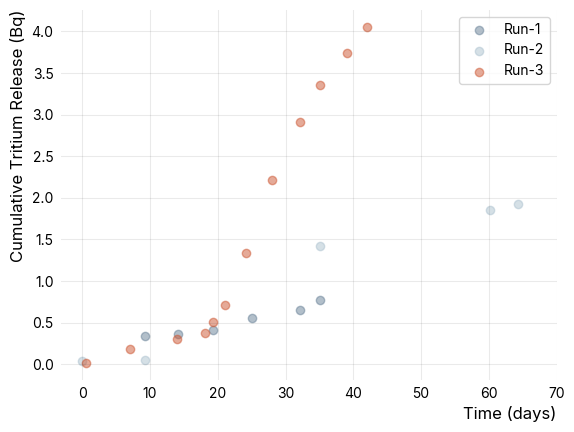

In [21]:
scatter_stream(data_1l_run_1, "OV", color=l1.get_color(), alpha=0.5, label="Run-1")
scatter_stream(data_1l_run_2, "OV", color=l2.get_color(), alpha=0.5, label="Run-2")
scatter_stream(data_1l_run_3, "OV", color=l3.get_color(), alpha=0.5, label="Run-3")


plt.xlim(right=70 * ureg.day)
plt.ylabel("Cumulative Tritium Release (Bq)", fontsize=12)
plt.xlabel("Time (days)", fontsize=12)
plt.legend()


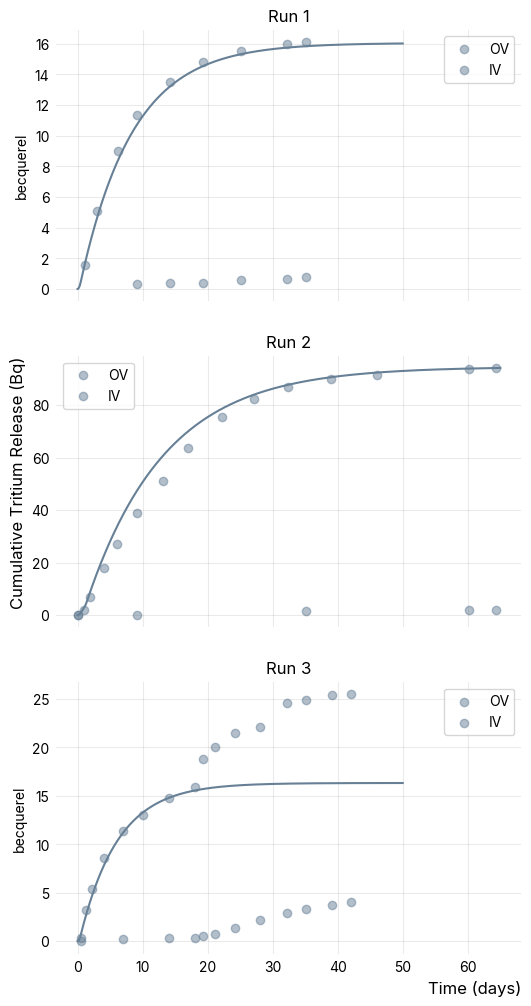

In [23]:
fig, axs = plt.subplots(3, 1, figsize=(6, 12), sharex=True)

for i, (model_run, data, label) in enumerate(
    zip([model_run_1, model_run_2, model_run_3], [data_1l_run_1, data_1l_run_2, data_1l_run_3], ["Run 1", "Run 2", "Run 3"])
):
    plt.sca(axs[i])
    scatter_stream(data, "OV", alpha=0.5, label="OV")
    l, = plot_integrated_top_release(model_run)
    scatter_stream(data, "IV", color=l.get_color(), alpha=0.5, label="IV")
    axs[i].set_title(label)
    axs[i].legend()

axs[1].set_ylabel("Cumulative Tritium Release (Bq)", fontsize=12)

axs[2].set_xlabel("Time (days)", fontsize=12)

plt.show()